In [17]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from skimage import measure
from tensorflow.keras.utils import to_categorical
import os
import math
import tqdm
import cv2 as cv
import enum

In [18]:
width, height = 14, 14

isoval_boundaries = {
"vertical_ellipse" : (1,7),
"horizontal_ellipse" : (1,7),
"heart" : (5,135),
"circle" : (25,169),
"hexagon" : (5,12)
}

shapes = {
"vertical_ellipse" : 1,
"horizontal_ellipse" : 2,
"heart" : 3,
"circle" : 4,
"hexagon" : 5
}

In [19]:
def get_shape(name, x,y):
    if name == "heart":
        return (x**2 + (y - np.sqrt(np.abs(x))) ** 2)
    elif name == "circle" or name == "hexagon":  #hexagon and circle share the same implicit function
        return x**2 + y**2
    elif name == "vertical_ellipse":
        x = (x - 5)**2 / 9
        y = (y + 1)**2 / 16
        return x + y
    elif name == "horizontal_ellipse":
        x = (x + 1)**2 / 16
        y = (y - 5)**2 / 9
        return x + y

In [20]:
def pad_square_matrix(m, p):
    offset = p - m.shape[1] 
    
    offset = offset // 2
    
    x = np.pad(m[0], offset, 'constant', constant_values=(0, 0))
    y = np.pad(m[1], offset, 'constant', constant_values=(0, 0))
    
    if (x.shape[0] != p):
        x = np.append(x, 0)
        y = np.append(y, 0)
    return np.array((x,y))

In [21]:
def gen_implicit_shape(shape_name):
    a = []
    for w in range(-width,width):
        for h in range(-height,height):
            a.append(get_shape(shape_name,w,h))
    
    np_arr = np.array(a).reshape(width * 2, height * 2)
    
    return np_arr

In [22]:
def gen_uniform_dataset(sample_size, pad_size,  persistent_save = False, shuffle = False):
    contours = []
    labels = []
    for shape_name in shapes.keys():

        isoval_bounds = isoval_boundaries[shape_name]
        boundary_pool = [bounds for bounds in range(isoval_bounds[0], isoval_bounds[1])]

        if sample_size > len(boundary_pool):
            isovals = []
            for i in range(sample_size):
                isovals.append(random.randint(isoval_bounds[0], isoval_bounds[1]))
        else:
            isovals = random.sample(boundary_pool, sample_size)

        for isoval in isovals:
            sample = measure.find_contours(gen_implicit_shape(shape_name), isoval)

            contours.append(  [sample[0][:,0] ,sample[0][:,1] ])
            labels.append((shapes[shape_name]))
            
    return contours, np.asarray(labels)

In [23]:
def gen_images_from_contours(data, IMG_W=28, IMG_H=28, external_save = False):
    images = [] 
    for img_i in tqdm.tqdm(range(len(data))):
        # create empty image
        image = np.zeros((IMG_W, IMG_H), np.uint8)

        coords_converted = [
            (math.ceil(x), math.ceil(y))
            for x, y in zip(data[img_i][0], data[img_i][1])
        ]
        # print(coords_converted)

        # draw coordinates
        for i in range(IMG_W):
            for j in range(IMG_H):
                if (i, j) in coords_converted:
                    image[i, j] = 255

        image = cv.rotate(image, cv.ROTATE_90_COUNTERCLOCKWISE)             
        images.append(image)
        
        if (external_save):
            if not os.path.exists("images"):
                os.makedirs("images")

            for file in os.listdir("images"):
                if (file != ".ipynb_checkpoints"):
                    os.remove(os.path.join("images", file))
            # save image
            cv.imwrite("images/shape_{}.png".format(img_i + 1), image)
        
    return images

In [24]:
df, dy = gen_uniform_dataset(500, 120,  True, True)

contours_as_images = gen_images_from_contours(df)
np.savez("dataset/shape_data" + ".npz", contours = contours_as_images, labels = dy)

100%|█████████████████████████████████████| 2500/2500 [00:02<00:00, 1024.56it/s]


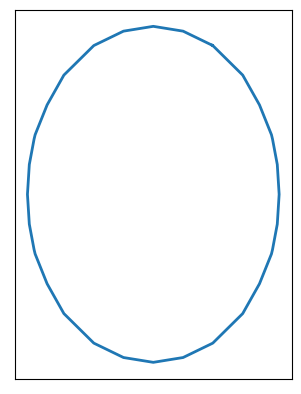

In [666]:
contours = df[459][0]
fig, ax = plt.subplots()

ax.plot(contours[0], contours[1], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()